# Modulation Classification

**To download and untar the dataset in colab:**

```bash
! mkdir -P /content/drive/MyDrive/datasets/deepsig
! wget -P /content/drive/MyDrive/datasets/deepsig https://f002.backblazeb2.com/file/deepsig-datasets/2016.10/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld
! mv /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
! tar -xvf /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2 -C /content/drive/MyDrive/datasets/deepsig/RML2016.10b
! rm /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
```

> Note : 
> The link will not work, you will have to request a link from the website.

## Imports and Constants

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy as sci
from scipy.integrate import cumulative_trapezoid
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.express as px


ROOT = '/kaggle/input/rml2016'
DAT = ROOT + '/RML2016.10b.dat'

## Loading and exploring the data

In [2]:
# from https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb
# modified for python 3
Xd = pickle.load(open(DAT, 'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
y = np.array(lbl)

X.shape, y.shape

((1200000, 2, 128), (1200000, 2))

In [3]:
# The labels
print(f'{np.unique(y[:,0],return_counts=True)}\n\n\
{np.unique(y[:,1],return_counts=True)}')

(array(['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16',
       'QAM64', 'QPSK', 'WBFM'], dtype='<U21'), array([120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000,
       120000, 120000]))

(array(['-10', '-12', '-14', '-16', '-18', '-2', '-20', '-4', '-6', '-8',
       '0', '10', '12', '14', '16', '18', '2', '4', '6', '8'],
      dtype='<U21'), array([60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000,
       60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000,
       60000, 60000]))


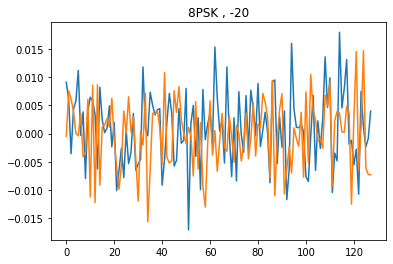

In [4]:
plt.plot(X[0,0])
plt.plot(X[0,1])
plt.title(f'{y[0,0]} , {y[0,1]}')
plt.show()

**Signal derivative**

In [5]:
d_np = np.gradient(X[0,0])

lines=[d_np,X[0,0]]

t = np.linspace(0,127,128)

fig = go.Figure()
fig.add_trace(go.Line(x=t,y=lines[0],name=f'derivative'))
fig.add_trace(go.Line(x=t,y=lines[1],name=f'original signal'))

fig.show()

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




**Signal Integral**

In [6]:
i_ct = cumulative_trapezoid(X[0,0])

lines=[i_ct,X[0,0]]

t = np.linspace(0,127,128)

fig = go.Figure()
fig.add_trace(go.Line(x=t,y=lines[0],name=f'cumulative trapezoid'))

fig.add_trace(go.Line(x=t,y=lines[1],name=f'original signal'))

fig.show()

## Creating Feature Spaces

Possible feature spaces:

1. raw signal
2. derivative
3. integration
4. raw and derivative
5. raw and integration
6. derivative and integration
7. raw and derivative and integration


In [7]:
X_raw = X
X_diff = np.gradient(X,axis=-1)
X_int = np.zeros_like(X)
X_int[:,:,:-1] = np.array(cumulative_trapezoid(X))

X_raw_diff = np.concatenate((X_raw,X_diff),axis=1)
X_raw_int = np.concatenate((X_raw,X_int),axis=1)
X_diff_int = np.concatenate((X_diff,X_int),axis=1)

X_all = np.concatenate((X_raw,X_diff,X_int),axis=1)

print(f'\
Shapes\n\
X_raw: {X_raw.shape}\n\
X_diff: {X_diff.shape}\n\
X_int: {X_int.shape}\n\n\
X_raw_diff: {X_raw_diff.shape}\n\
X_raw_int: {X_raw_int.shape}\n\
X_diff_int: {X_diff_int.shape}\n\n\
X_all: {X_all.shape}')

Shapes
X_raw: (1200000, 2, 128)
X_diff: (1200000, 2, 128)
X_int: (1200000, 2, 128)

X_raw_diff: (1200000, 4, 128)
X_raw_int: (1200000, 4, 128)
X_diff_int: (1200000, 4, 128)

X_all: (1200000, 6, 128)


## Data Splitting

In [8]:
def split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state =1, stratify = y[:,0])
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.05, random_state =1, stratify = y_train[:,0])
    return x_train, x_val, x_test, y_train, y_val, y_test